In [1]:
# using tensorflow_gpuenv

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import requests, zipfile, io
import scipy
import time

hello=tf.constant('Hello,TensorFlow!')

sess=tf.Session()

print(sess.run(hello))


b'Hello,TensorFlow!'


## Getting the vocabulary

We determine our vocabulary by looking at the Google "English 1 Million" unigram data. Since this comes from the same source as the ngram data we will be studying, this provides consistnecy. Additionally, since this data is drawn from sources spanning the time period we're studing, it can be expected to be more representative of english over this broader time period, while other sources may reflect a more modern english.

### Tokenizing

In order to simplify the text we're looking at, all text is converted to lowercase and all "words" composed entirely of non-alphabetic symbols are replaced with a "#NUM" tag. If a non-alphabetic symbol appears partway through a word (e.g. an apostrophe or hyphen), only the first part of the word will be recorded.

In [2]:
all_words = {}

def clean_word(string):
    wordlist = re.findall(r"[a-z]+", string.lower())
    word = ""
    if len(wordlist) == 0:
        word = "#NUM"
    else:
        word = wordlist[0]
    return word
    

def get_word_counts(data, all_words):
    worddata = data.groupby("word")["total"].sum()
    for index, value in worddata.iteritems():
        currentword = str(index)
        word = clean_word(currentword)
        if word in all_words:
            all_words[word] += value
        else:
            all_words[word] = value

In [3]:
for i in range(10):
    filename = "googlebooks-eng-1M-1gram-20090715-" + str(i) + ".csv"
    data = pd.read_csv(filename, 
                       sep = '\t', 
                       header = None, 
                       names = ["word","year","total","pages","books"],
                       quotechar=None, 
                       quoting=3,
                       encoding = "ISO-8859-1")
    print(data.head())
    get_word_counts(data, all_words)

  word  year  total  pages  books
0    #  1574      1      1      1
1    #  1584      6      6      1
2    #  1614      1      1      1
3    #  1631    115    100      1
4    #  1632      3      3      1
  word  year  total  pages  books
0    $  1520      1      1      1
1    $  1575     12     12      2
2    $  1576      1      1      1
3    $  1581      1      1      1
4    $  1584     41     38      1
     word  year  total  pages  books
0  $0.007  1905      1      1      1
1  $0.007  1910      2      2      2
2  $0.007  1911      3      3      3
3  $0.007  1912      6      6      6
4  $0.007  1913      4      4      4
    word  year  total  pages  books
0  $0.00  1751      1      1      1
1  $0.00  1782      1      1      1
2  $0.00  1834      1      1      1
3  $0.00  1848      2      2      2
4  $0.00  1849      1      1      1
     word  year  total  pages  books
0  $0.002  1906      1      1      1
1  $0.002  1908      2      2      2
2  $0.002  1909      5      5      5
3  $0.

In [4]:
keys = random.sample(list(all_words), 1000)
print(keys[:10])

['ponsan', 'swedenborgianism', 'creagan', 'rsvps', 'kubo', 'triaminic', 'azuru', 'marcomannic', 'macmillaris', 'atioc']


In [5]:
len(all_words)

2017739

gonococci
28282
nonmaterial
13099
reiter
35558
erma
10450
sapienza
10709
standley
10869
hackney
153041
tanzania
142857
askari
11440
decreeing
36886
sawyers
24222
somersault
26909
workers
8760559
inspirited
13606
officium
30314
cem
23117
tripling
11103
rawley
17715
stiffen
63565
saps
33196
gratiae
11882
kk
105720
mahavira
17505
talkin
51147
graveled
12301
bells
1179691
seventhly
17002
vallier
11849
coffees
14376
hoffmann
164934
catalans
36061
rioters
151408
goodly
394318
coleman
339544
stylized
81242
halides
75936
kutch
20305
cadastre
10412
kluckhohn
25712
zip
68455
irruption
90053
tellier
19509
lier
41194
lupine
17923
antipyretics
13431
rescripts
17870
jordanes
11390
pallbearers
11472
dundalk
27854
incipit
23860
flamingo
31120
alginate
18758


(array([998.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.0000000e+01, 8.7609190e+05, 1.7521438e+06, 2.6281957e+06,
        3.5042476e+06, 4.3802995e+06, 5.2563514e+06, 6.1324033e+06,
        7.0084552e+06, 7.8845071e+06, 8.7605590e+06]),
 <a list of 10 Patch objects>)

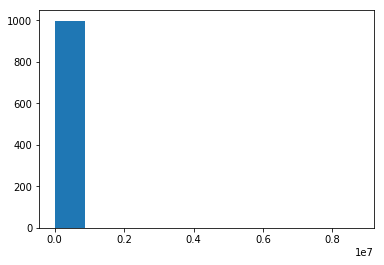

In [6]:
counts = []
for word in keys:
    count = all_words[word]
    counts.append(count)
    if(count>1e4):
        print(word)
        print(count)
plt.hist(counts)

In [7]:
top_words = {}
word_to_index = {}
index_to_word = {}
cutoff = 5e4
top_word_count = 0
extra_word_count = 0
i = 0
words = []
counts = []
for word, count in all_words.items():
    if(count>cutoff):
        top_words[word] = count
        top_word_count += count
        words.append(word)
        counts.append(count)
        #word_to_index[word] = i
        #index_to_word[i] = word
        i += 1
    else:
        extra_word_count += count

indices = np.argsort(-1*np.array(counts))
for order, index in enumerate(indices):
    word_to_index[words[index]] = order
    index_to_word[order] = words[index]
        
print(str(len(top_words)) + " words")
print("appearing " + str(top_word_count) + " times")
print("others appear " + str(extra_word_count) + " times")

44054 words
appearing 108532409422 times
others appear 2464883135 times


In [8]:
print(word_to_index["the"])
print(word_to_index["man"])
print(word_to_index["calculate"])

1
88
6597


In [9]:
print(top_word_count/(extra_word_count + top_word_count))

0.9777933039787055


In [10]:
pd.DataFrame.from_dict(top_words, orient='index').to_csv("vocabCountsLarge.csv")
pd.DataFrame.from_dict(index_to_word, orient='index').to_csv("vocabIndexedLarge.csv")

In [11]:
# if re-running: 
def load_vocab(top_word_dict, word_to_index_dict, index_to_word_dict):
    top_word_df = pd.read_csv("vocabCounts.csv", names=["word","count"], header=0)
    total_count = 0
    for index, row in top_word_df.iterrows():
        top_word_dict[row["word"]] = row["count"]
        total_count += row["count"]
        word_to_index_dict[row["word"]] = index
        index_to_word_dict[index]=row["word"]
    return total_count
    
#top_words = {}
#word_to_index = {}
#index_to_word = {}

#total_count = load_vocab(top_words, word_to_index, index_to_word)
#print(total_count)
    

In [12]:
maxyear = 2008
minyear = 1900

decades = list(range(minyear - minyear%10, maxyear, 10))
decades

[1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]

According to Mikolov, the best results from skipgram came from training with a loss function of negative sampling with k=15. This means using "tf.nn.sampled_softmax_loss" with num_sampled = 15, num_classes = vocab size, and num_true=1.
source: https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss

From hw4:

embed_shape = [self.V, self.H]

self.W_in_ = tf.get_variable("W_in", embed_shape, initializer=tf.initializers.random_uniform(minval=-1.0,maxval=1.0))

x_in_ = tf.nn.embedding_lookup(self.W_in_, self.input_w_)

In [13]:
vocab_size = len(top_words) + 1
embed_dim = 300
neg_samples = 15
learning_rate_ = .001

In [36]:
W_e_ = {}
W_nce_ = {}
b_nce_ = {}

print("Data from " + str(minyear) + " to " + str(maxyear))
for decade in decades:
    # initialize embeddings
    with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE): 
        W_e_[decade] = tf.get_variable("W_e_" + str(decade), 
                       [vocab_size, embed_dim], 
                       initializer = tf.initializers.random_uniform(minval=-1.0,
                                                                    maxval=1.0, 
                                                                    seed = 47))
        W_nce_[decade] = tf.get_variable("W_nce_" + str(decade), 
                      [vocab_size, embed_dim], 
                      initializer = tf.initializers.random_uniform(minval=-1.0,
                                                                   maxval=1.0, 
                                                                   seed = 47))
        b_nce_[decade] = tf.get_variable("b_nce_" + str(decade), 
                       [vocab_size])

Data from 1900 to 2008


follow the directions in https://www.tensorflow.org/tutorials/representation/word2vec to get skipgram model running

In [37]:
v_center_ = {}
train_loss_ = {}
train_step_ = {}

batch_size = 8

center_word_ids_ = tf.placeholder(tf.int32, [batch_size])
context_word_ids_ = tf.placeholder(tf.int32, [batch_size,1])

for decade in decades:

    v_center_[decade] = tf.nn.embedding_lookup(W_e_[decade], center_word_ids_)
    
    
    train_loss_[decade] = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=W_nce_[decade],
                 biases=tf.zeros([vocab_size]),
                 labels=context_word_ids_,
                 inputs=v_center_[decade],
                 num_sampled=neg_samples,
                 num_classes=vocab_size))
    
    train_step_[decade] = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(train_loss_[decade])
    
init=tf.global_variables_initializer()

In [38]:
def words_to_indices(wordlist, wordindices):
    indexlist = [vocab_size - 1,vocab_size -1,vocab_size -1,vocab_size -1,vocab_size -1]
    for i in range(len(wordlist)):
        currentword = wordlist[i]
        cleanword = clean_word(currentword)
        if(cleanword in wordindices):
            indexlist[i] = wordindices[cleanword]
    #indextuple = tuple(indexlist)
    return indexlist

def ngram_to_df(fileurl):
    #response = requests.get(fileurl)
    #zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    #zip_file.extractall("temp")
    
    decade_data = {}
    for decade in decades:
        # initialize dictionary
        decade_data[decade] = {}
        
    data = 0
    start = time.time()
    while True:
        try:
            data = pd.read_csv(fileurl, 
                       sep = '\t', 
                       header = None, 
                       names = ["words","year","total","pages","books"],
                       quotechar=None, 
                       quoting=3,
                       encoding = "ISO-8859-1")
        except:
            print("trying downloading "+ fileurl + " again... ")
        else:
            break
    end = time.time()
    print(str(end-start) + " elapsed while downloading and reading")
    for decade in decades:
        decade_data[decade] = data.loc[(data['year'] >= decade) & (data['year'] < decade+10)]
    
    return decade_data

In [39]:
sess.run(init)

run skipgram for each decade

In [41]:
max_iter = 501

for filenum in range(23,800):
    url = "http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-1M-5gram-20090715-" + str(filenum) +".csv.zip"
    print("downloaded " + url)
    #decade_dicts = ngram_to_decade_dict(url, word_to_index, decades)
    decade_data =  ngram_to_df(url)
    for decade in decades:
        num_ngrams = len(decade_data[decade])
        totalcost = 0
        itercount = 0
        if(num_ngrams >= batch_size):
            print("Training decade " + str(decade))
            max_decade_iter = min(max_iter, int(num_ngrams/(batch_size)))
            for iteration in range(max_decade_iter):
                traindf = decade_data[decade].sample(n=batch_size, weights='total')
                trainarray = np.zeros([batch_size,5])
                i=0
                for index, row in traindf.iterrows():
                    trainarray[i] = words_to_indices(str(row["words"]).lower().split(" "), word_to_index)
                    i+=1
                    
                for i in range(5):
                    for j in range(5):
                        if(i != j):
                            feed_dict = {
                                context_word_ids_ : np.array([x[i] for x in trainarray]).reshape((batch_size,1)),
                                center_word_ids_ : [x[j] for x in trainarray],
                            }

                            ops = [train_loss_[decade], train_step_[decade]]        

                            cost, _ = sess.run(ops, feed_dict)
                            totalcost+= cost
                            itercount +=1
                
                if(iteration % 100 == 0):
                    print(str(totalcost*1.0/itercount))     
                    totalcost = 0
                    itercount = 0

downloaded http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-1M-5gram-20090715-23.csv.zip
trying downloading http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-1M-5gram-20090715-23.csv.zip again... 
22.271231651306152 elapsed while downloading and reading
Training decade 1900
4.091782438755035
2.9632691305279732
3.0513360950946806


KeyboardInterrupt: 

In [42]:
last_decade = decades[-1]
most_recent_embed = sess.run(W_e_[last_decade])
aligned_embeddings = {}
embeddings = {}


# align past decades to current english using orthogonal procrustes
for i, decade in enumerate(decades):
    decade_embed =  sess.run(W_e_[decade])
    embeddings[decade] = decade_embed
    conversion = scipy.linalg.orthogonal_procrustes(decade_embed, most_recent_embed)
    print(str(decade) + " aligns with svd sum "+str(conversion[1]))
    aligned = np.dot(decade_embed, conversion[0])
    aligned_embeddings[decade] = aligned
    np.savetxt("embeddings_" + str(decade) + ".csv", aligned)

1900 aligns with svd sum 4316302.0
1910 aligns with svd sum 4318010.5
1920 aligns with svd sum 4319151.0
1930 aligns with svd sum 4319660.0
1940 aligns with svd sum 4320381.5
1950 aligns with svd sum 4320167.5
1960 aligns with svd sum 4321094.5
1970 aligns with svd sum 4322289.5
1980 aligns with svd sum 4323611.0
1990 aligns with svd sum 4325492.0
2000 aligns with svd sum 4349451.0


In [43]:
def embedding_lookup(word,embeddingmx):
    wordindex = len(word_to_index)
    if(word in word_to_index):
        wordindex = word_to_index[word]
    embedding = embeddingmx[wordindex]
    return embedding
    
def cos_sim(x,y):
    return np.dot(x,y)/np.sqrt(np.dot(x,x)*np.dot(y,y))

def cos_sim_words(x, y, embeddingmx):
    x_embed = embedding_lookup(x,embeddingmx)
    y_embed = embedding_lookup(y,embeddingmx)
    return cos_sim(x_embed, y_embed)

def cos_sim_time(word1, word2, decades, embedding_dict):
    sims = np.zeros(len(decades))
    for i, decade in enumerate(decades):
        word1embed = embedding_lookup(word1, embedding_dict[decade])
        word2embed = embedding_lookup(word2, embedding_dict[decade])
        cos = cos_sim(word1embed, word2embed)
        sims[i] = cos
    return sims

def normalize(x):
    xnorm = np.sqrt(np.dot(x,x))
    if(xnorm == 0):
        return x
    else:
        return x/xnorm

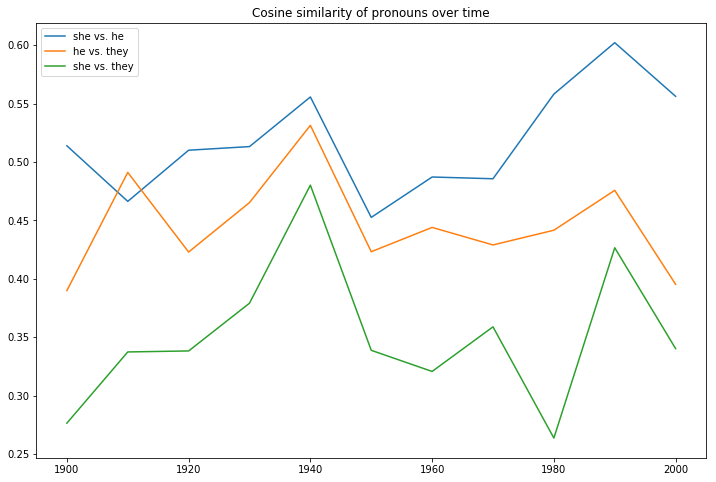

In [44]:
plt.figure(figsize=(12,8))
plt.title("Cosine similarity of pronouns over time")
plt.plot(decades, cos_sim_time("she","he",decades,embeddings), label='she vs. he')
plt.plot(decades, cos_sim_time("he","they",decades,embeddings), label='he vs. they')
plt.plot(decades, cos_sim_time("she","they",decades,embeddings), label='she vs. they')
plt.legend()

In [45]:
# visualize on "he-she" projection vs time   

    

def eval_analogy(a, b, c, d, embedding):
    embeda = normalize(embedding_lookup(a, embedding))
    embedb = normalize(embedding_lookup(b, embedding))
    embedc = normalize(embedding_lookup(c, embedding))
    embedd = normalize(embedding_lookup(d, embedding))
    target = embedc-embeda+embedb
    return cos_sim(target, embedd)
        
def eval_analogy_time(a, b, c, d, decades, embedding_dict):
    cos_sim = np.zeros(len(decades))
    for i, decade in enumerate(decades):
        cos = eval_analogy(a,b,c,d, embedding_dict[decade])
        cos_sim[i] = cos
    return cos_sim


graph results

IndexError: list index out of range

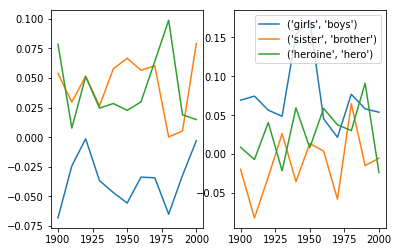

In [46]:
a = "she"
b = "he"

bolubasi_biased = [("nurse", "surgeon"),
                   ("blonde", "burly"),
                   ("feminism","conservatism")]

bolubasi_appropriate = [("girls","boys"),
                        ("sister","brother"),
                        ("heroine","hero"),
                        ("queen","king")]

fig, axes = plt.subplots(1, 2, sharex='col', sharey='col')
for i in range(5):
    pair = bolubasi_biased[i]
    axes[0].plot(decades,eval_analogy_time(a,b,pair[0],pair[1], decades, embeddings))
    pair = bolubasi_appropriate[i]
    axes[1].plot(decades,eval_analogy_time(a,b,pair[0],pair[1], decades, embeddings), label =str(pair))
    axes[1].legend()


In [49]:
def complete_analogy(a,b,c, embeddings):
    embeda = embedding_lookup(a, embeddings)
    embedb = embedding_lookup(b, embeddings)
    embedc = embedding_lookup(c, embeddings)
    target = embedc - embeda + embedb
    maxsim = 0
    maxword = ""
    for word, index in word_to_index.items():
        if(word != c and word != b):
            wordembed = embedding_lookup(word, embeddings)
            cos = cos_sim(target, wordembed)
            if(cos > maxsim):
                maxword = word
                maxsim = cos
    return maxword
        
decade = 1900
print(complete_analogy("queen","woman","king", embeddings[decade]))
print(complete_analogy("man","woman","uncle", embeddings[decade]))
print(complete_analogy("man","woman","brother", embeddings[decade]))
print(complete_analogy("man","woman","boy", embeddings[decade]))
print(complete_analogy("he","she","man", embeddings[decade]))       

therapeutics
insinuated
cabin
coupling
make


In [ ]:
def check_analogy(a,b,c,d,embeddings):
    answer = complete_analogy(a,b,c,embeddings)
    # print(a + ' ' + b + ' ' + c  + ' ...' + answer + " (correct : " + d +")")
    if(answer == d):
        return 1
    else:
        return 0


with open('analogy-checks-from-tf.txt') as f:
    lines = f.readlines()
    
lines = [x.strip().split(" ") for x in lines] 
lines_filtered = list(filter(lambda x: len(x) == 4, lines[-100:]))
total_analogies = len(lines_filtered)
accuracies = np.zeros(len(decades))
for i, decade in enumerate(decades):
    correct = [check_analogy(x[0],x[1],x[2],x[3],embeddings[decade]) for x in lines_filtered]
    accuracy = sum(correct) * 1.0 / total_analogies
    accuracies[i] = accuracy
    print(str(decade) + " with accuracy: " + str(accuracy))
    
plt.plot(decades, accuracies)
plt.show()

In [50]:
def weat(targetX, targetY, attrA, attrB, embeddings):
    x_sum = 0
    y_sum = 0
    a_total = len(attrA)
    b_total = len(attrB)
    for x in targetX:
        a_x_total = 0
        for a in attrA:
            a_x_total += cos_sim_words(x, a, embeddings)
        b_x_total = 0
        for b in attrB:
            b_x_total += cos_sim_words(x, b, embeddings)
        x_sum += a_x_total*1.0/a_total - b_x_total*1.0/b_total
    for y in targetY:
        a_y_total = 0
        for a in attrA:
            a_y_total += cos_sim_words(y, a, embeddings)
        b_y_total = 0
        for b in attrB:
            b_y_total += cos_sim_words(y, b, embeddings)
        y_sum += a_y_total*1.0/a_total - b_y_total*1.0/b_total
    return x_sum - y_sum

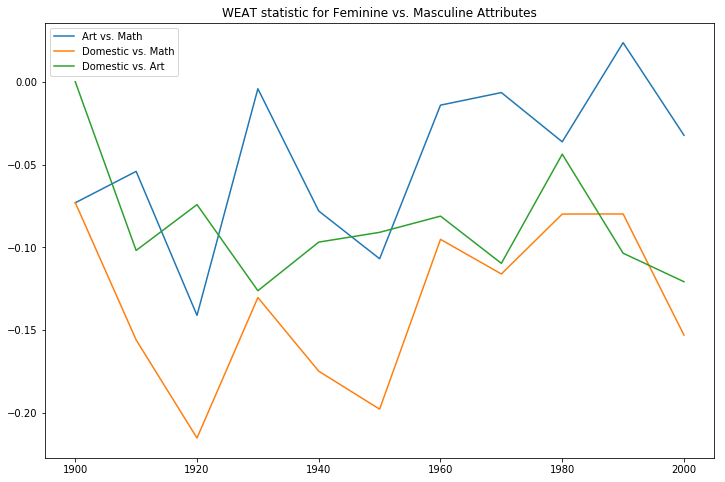

In [51]:
target_art = ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"]
target_math = ["math", "algebra", "geometry", "calculus", "equations", "computation", "numbers", "Newton"]
target_science = ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"]

target_domestic = ["house", "home", "clean", "sew", "children", "cook", "garden", "laundry"]
target_intellectual = ["college", "learn", "book", "write", "study", "art", "science", "math"]

attr_fem = ["sister", "mother", "aunt", "grandmother", "daughter", "she", "hers", "her"]
attr_masc = ["brother", "father", "uncle", "grandfather", "son", "he", "his", "him"]

weat_art_math = np.zeros(len(decades))
weat_art_science = np.zeros(len(decades))
weat_dom_math =  np.zeros(len(decades))
weat_dom_science =  np.zeros(len(decades))
weat_dom_art =  np.zeros(len(decades))

for i, decade in enumerate(decades):
    weat_art_math[i] = weat(target_art, target_math, attr_fem, attr_masc, embeddings[decade])
    weat_art_science[i] = weat(target_art, target_science, attr_fem, attr_masc, embeddings[decade])
    weat_dom_math[i] = weat(target_domestic, target_math, attr_fem, attr_masc, embeddings[decade])
    weat_dom_science[i] = weat(target_domestic, target_science, attr_fem, attr_masc, embeddings[decade])
    weat_dom_art[i] = weat(target_domestic, target_art, attr_fem, attr_masc, embeddings[decade])
    
    
plt.figure(figsize=(12,8))
plt.title("WEAT statistic for Feminine vs. Masculine Attributes")
plt.plot(decades,weat_art_math, label = "Art vs. Math")
#plt.plot(decades,weat_art_science)
#plt.show()
plt.plot(decades,weat_dom_math, label = "Domestic vs. Math")
#plt.plot(decades,weat_dom_science)
plt.plot(decades,weat_dom_art, label = "Domestic vs. Art")
plt.legend()
plt.show()